In [23]:
### imports ###
import pygmt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.image as mpimg 
from mpl_toolkits.basemap import Basemap

import pandas as pd
import xarray as xr
%matplotlib inline
%matplotlib widget

In [3]:
# Major tectonic blocks and faults are marked by black lines (after Styron et al. (2010) and Taylor and An Yin (2009))
# https://github.com/HimaTibetMap/HimaTibetMap/tree/master
# Styron, R., Taylor, M., and Okoronkwo, K., 2010, HimaTibetMap-1.0: new ‘web-2.0’ online database of active structures from the Indo-Asian collision, Eos, vol.91 no. 20.
# Taylor, Michael, and An Yin, 2009, "Active structures of the Himalayan-Tibetan orogen and their relationships to earthquake distribution, contemporary strain field, and Cenozoic volcanism." Geosphere vol. 5, no. 3, pp 199-214.
# gem_active_faults.gmt https://github.com/GEMScienceTools/gem-global-active-faults
# Slab contours are from the slab model of Hayes et al. (2018).
# Hayes, G., 2018, Slab2 - A Comprehensive Subduction Zone Geometry Model: U.S. Geological Survey data release, https://doi.org/10.5066/F7PV6JNV. 

# Seismicity from the Harvard CMT cffatalogue (Dziewonski et al. (1981), Ekstr ̈om et al. (2012), https://www.globalcmt.org/.
# InSAR DURATION ONLY 20160309 20240710


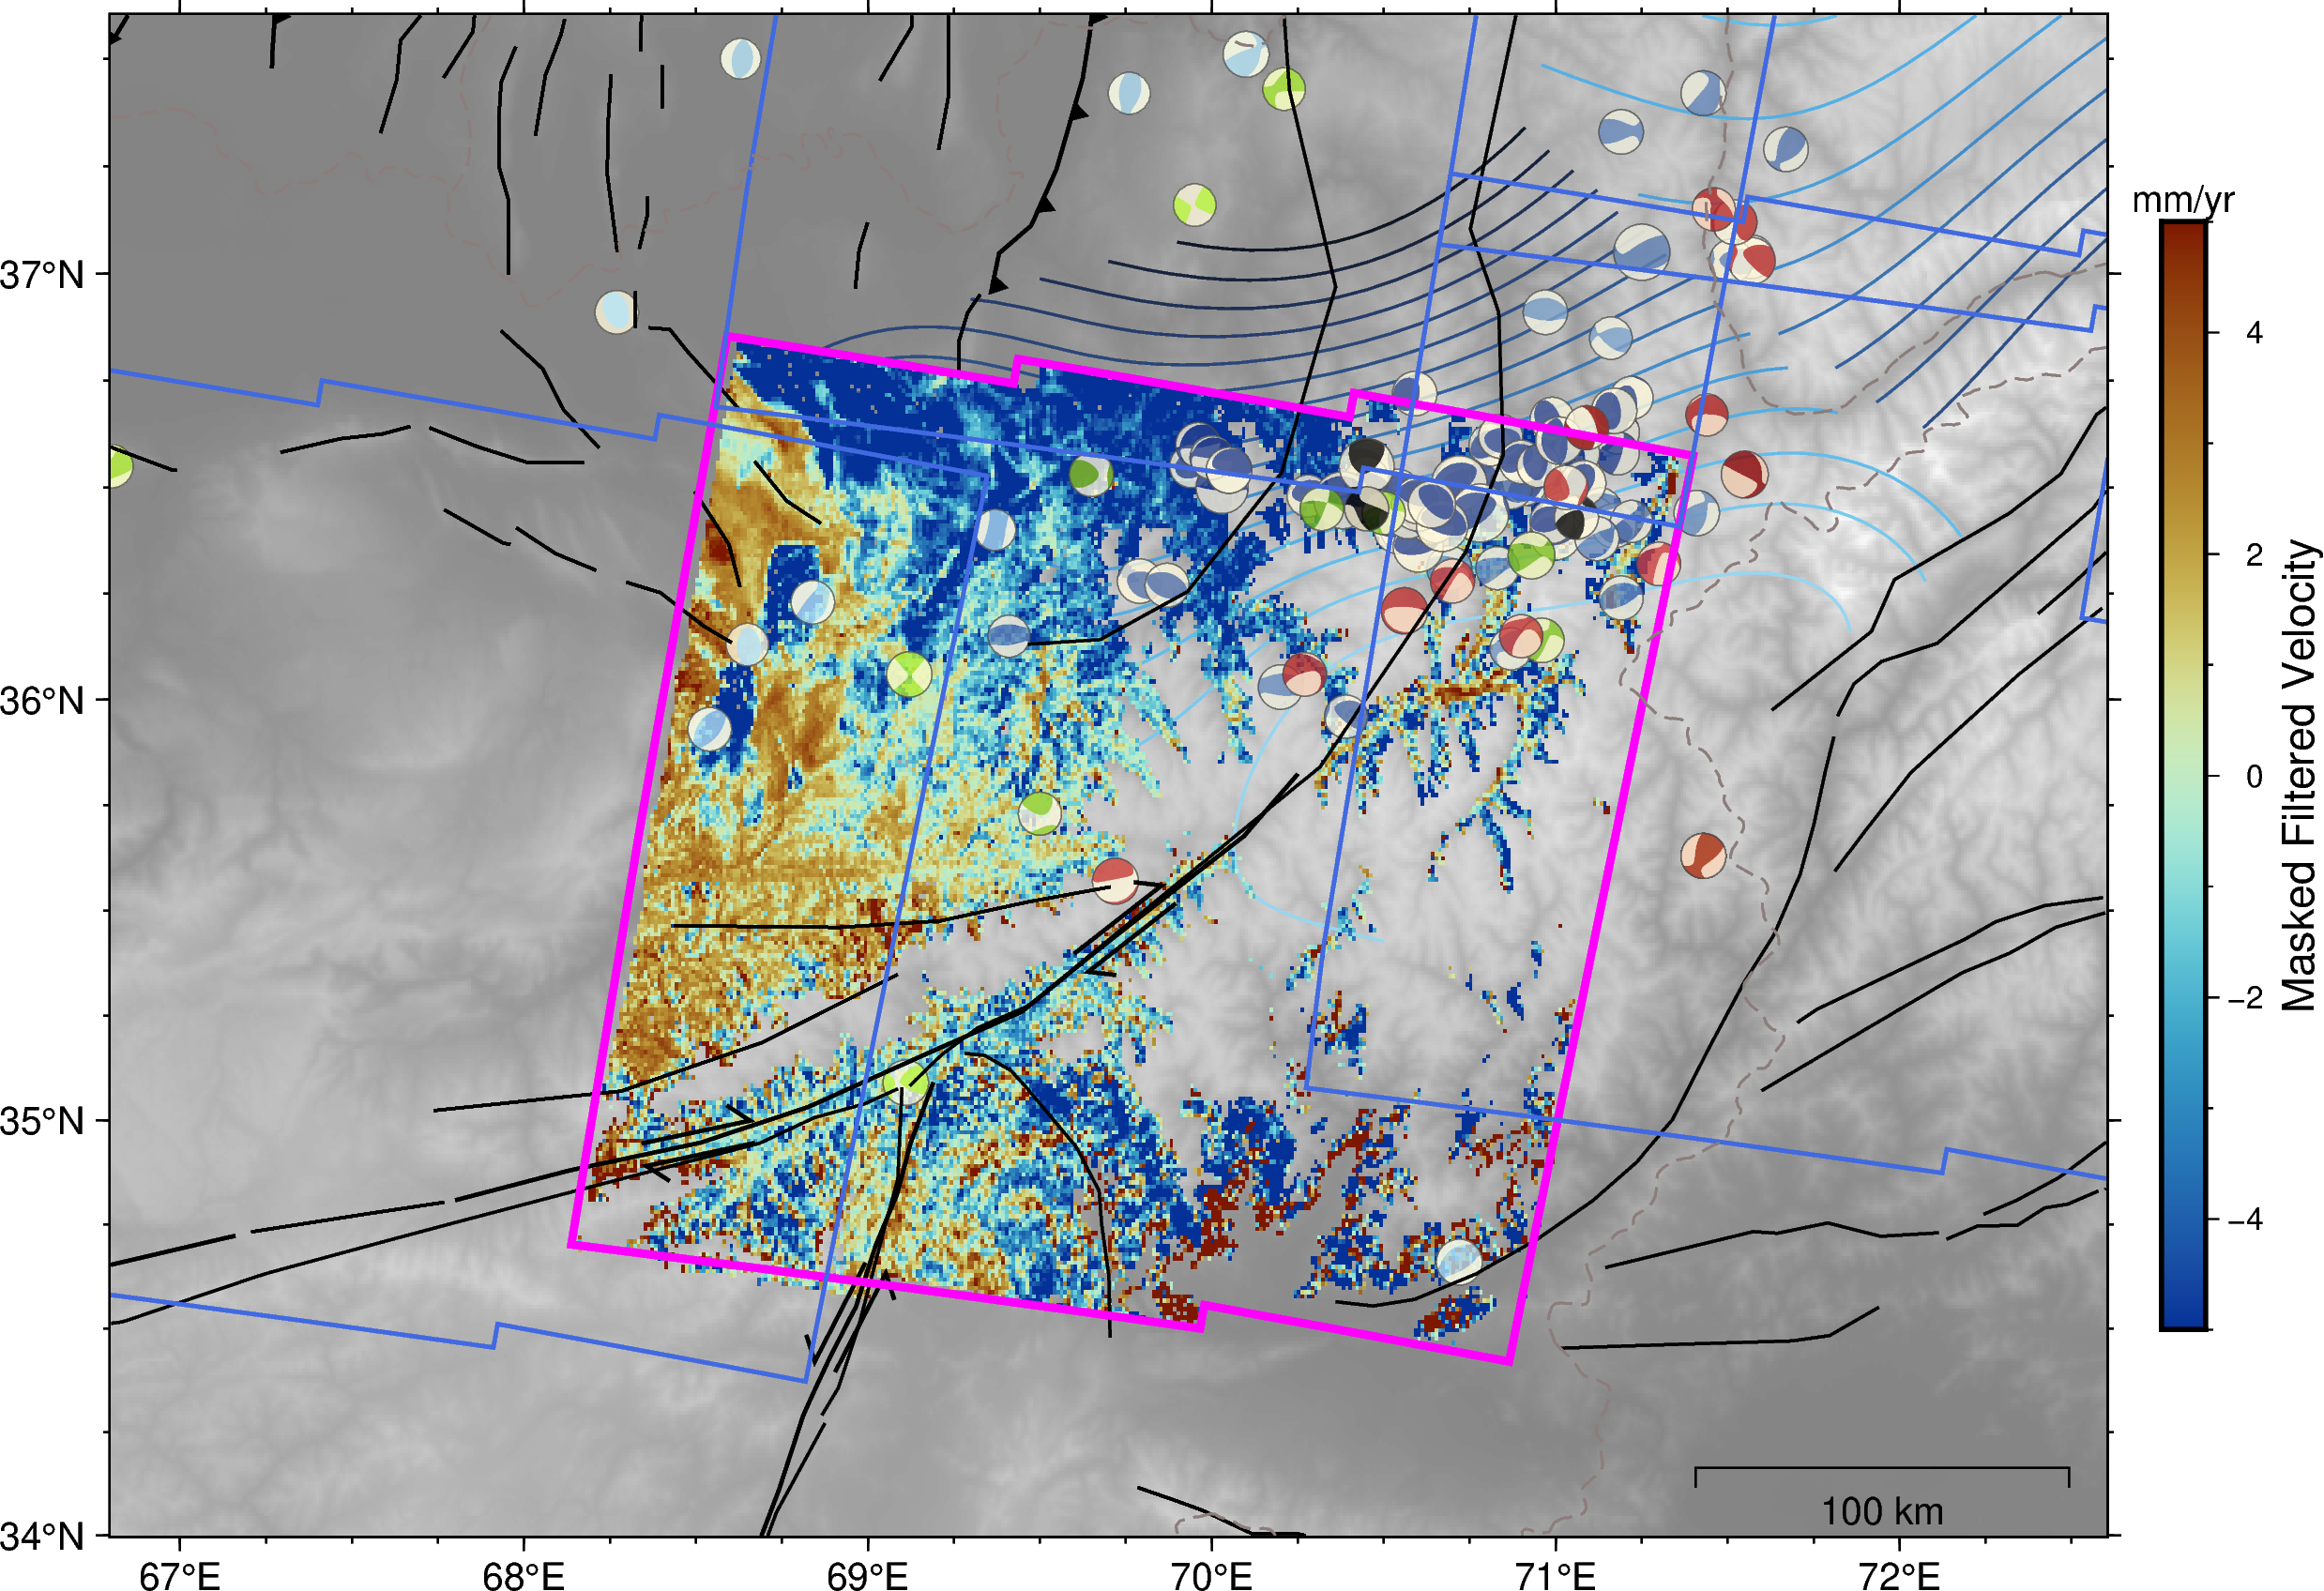

In [46]:
### GMT basemap ###
import os
dir = "/Users/rochelle/Documents/GitHub/Leeds-Research-Internship/"
os.chdir(dir)

###########################################
## Specify coords
# llcrnrlat,llcrnrlon, urcrnrlat, urcrnrlon
# are the lat/lon values of the lower left and upper right corners of the map

llcrnrlon=66.8 # lower left corner longitude 
llcrnrlat=34 # lower left corner latitude
urcrnrlon=72.6 # upper right corner longitude
urcrnrlat=37.6 # upper right corner latitude


proj_scale_w = 18 # specify projection scale (width)
proj_scale_unit = "c" # choose between c (cm) and i (inches)
# 17.78c = 7i

meca_trans = 22 # meca transparency
meca_scale = "0.4c" # meca scale

# InSAR_tif ="071A_05440_131313_2.vel.filt.mskd.geo.tif"
InSAR_NetCDF = "078D_05435_131313_Milan.nc"
###########################################

centerlon = (urcrnrlon - llcrnrlon)/2 + llcrnrlon # midpoints
centerlat = (urcrnrlat - llcrnrlat)/2 + llcrnrlat
region=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]



fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain") # figure config (borders)
fig.coast(region=region,\
          projection="M%s/%s/%s%s" % (centerlon, urcrnrlat, proj_scale_w, proj_scale_unit),\
          water="white", land="grey", shorelines="1/0.5p",\
          frame=["WSne", "a1f0.25"])

          # Mercator
          # a2f0.5 --> major ticks every 2 and minor ticks every 0.5

grid = pygmt.datasets.load_earth_relief("30s", registration="gridline", region=region)

fig.grdimage(grid=grid, cmap="bin/cpt/custom/seabluelandgrey.cpt")
# fig.grdimage(grid=grid, cmap="geo")

## plot slab2.0 here
fig.plot(data="bin/hin_slab2_dep_02.24.18_contours.in", pen=f"0.65p", cmap="bin/cpt/abyss_slab2.0") # Hindu Kush, bounding coords 66 74 40 34
fig.plot(data="bin/pam_slab2_dep_02.26.18_contours.in", pen=f"0.65p", cmap="bin/cpt/abyss_slab2.0") # Pamir, bounding coords 68 78 41 35


## plotting vel TEST
pygmt.makecpt(output="bin/cpt/roma_InSAR", series=[-5, 5], reverse=True, cmap="bin/cpt/GMT_supported/roma.cpt")
              # redefine scale + inverse
              # stored in local sesh

ncarray = xr.open_dataset("bin/" + InSAR_NetCDF)
vel = ncarray["vel"]
mskd = ncarray["mask"]
vel_mskd = vel * mskd
vel_mskd = vel_mskd.where(vel_mskd != 0, np.nan)



# fig.grdimage(grid=("bin/" + InSAR_NetCDF + "?vel"), nan_transparent = True, transparency = 0, cmap="bin/cpt/roma_InSAR")
# fig.grdimage(grid=("bin/" + InSAR_NetCDF + "?mask"), nan_transparent = "+z1", transparency = 0, cmap="bin/cpt/roma_InSAR")

fig.grdimage(grid=vel_mskd, nan_transparent = True, transparency = 0, cmap="bin/cpt/roma_InSAR")

## plotting HarvardCMT earthquakes by fault style 20160309 20240710
fig.meca(
    spec="bin/Harvard_CMT_InSAR/Harvard_CMT_InSAR_thrust_dropname.xy",
    convention="mt", scale=meca_scale,
    cmap="bin/cpt/custom/blue.cpt",
    extensionfill="cornsilk",
    # Draw a 0.5 points thick dark gray ("gray30") solid outline via
    # the pen parameter [Default is "0.25p,black,solid"]
    pen="thinnest,gray30,solid", transparency=meca_trans,
)

fig.meca(
    spec="bin/Harvard_CMT_InSAR/Harvard_CMT_InSAR_ss_dropname.xy",
    convention="mt", scale=meca_scale,
    cmap="bin/cpt/custom/green.cpt",
    extensionfill="cornsilk",
    pen="thinnest,gray30,solid", transparency=meca_trans,
)

fig.meca(
    spec="bin/Harvard_CMT_InSAR/Harvard_CMT_InSAR_normal_dropname.xy",
    convention="mt", scale=meca_scale,
    cmap="bin/cpt/custom/red.cpt",
    extensionfill="cornsilk",
    pen="thinnest,gray30,solid", transparency=meca_trans,
)




## plotting faults
# https://www.pygmt.org/dev/gallery/lines/linefronts.html
fig.plot(data="bin/faults/HimaTibetMap.gmt", pen=f"0.7p,black") # all faults
fig.plot(data="bin/faults/gem_active_faults.gmt", pen=f"0.7p,black") # gem
fig.plot(data="bin/faults/normal.gmt", style="f1c/0.13c+l+b", pen=f"0.95p,black", fill="black") # normal
fig.plot(data="bin/faults/thrust.gmt", style="f1c/0.13c+l+t", pen=f"0.95p,black", fill="black") # thrust
fig.plot(data="bin/faults/dextral.gmt", style="f5c/1c+r+s45+o2.25c", pen=f"0.95p,black", fill="black") # dextral (right)
fig.plot(data="bin/faults/sinistral.gmt", style="f5c/1c+l+s45+o2.25c", pen=f"0.95p,black", fill="black") # sinistral (left)


## plotting poly.txt

### Descending ###
fig.plot(data="bin/metadata/descending/078D_05435_131313-poly.txt", pen=f"2p,magenta") # 078D_05435_131313
fig.plot(data="bin/metadata/descending/005D_05398_131313-poly.txt", pen=f"1p,royalblue") # 005D_05398_131313
fig.plot(data="bin/metadata/descending/151D_05440_131313-poly.txt", pen=f"1p,royalblue") # 151D_05440_131313
fig.plot(data="bin/metadata/descending/078D_05237_131313-poly.txt", pen=f"1p,royalblue") # 078D_05237_131313
fig.plot(data="bin/metadata/descending/005D_05199_131313-poly.txt", pen=f"1p,royalblue") # 005D_05199_131313
fig.plot(data="bin/metadata/descending/107D_05290_121313-poly.txt", pen=f"1p,royalblue") # 107D_05290_121313
fig.plot(data="bin/metadata/descending/107D_05092_141313-poly.txt", pen=f"1p,royalblue") # 107D_05092_141313-poly.txt

'''
## plotting reference points

fig.plot(data="bin/metadata/" + InSAR_tif.strip(".vel.filt.mskd.geo.tif") + "_13ref.gmt", style="a0.38c", pen="thinnest", fill="orange")
fig.plot(data="bin/metadata/" + InSAR_tif.strip(".vel.filt.mskd.geo.tif") + "_16ref.gmt", style="a0.38c", pen="thinnest", fill="cyan")
'''

## legends and stuff

fig.coast(map_scale="g71.95/34.14+w100k", shorelines="1/0.5p", borders="1/0.6p, mistyrose4,-")
fig.colorbar(
    cmap="bin/cpt/roma_InSAR", frame=["xa2f1+lMasked Filtered Velocity", "y+lmm/yr"],
    # offset (+o) by 0.5 cm horizontally and 0.8 cm vertically from anchor
    # point, and plotted horizontally (+h)
    position="JCR+o0.5/0c+w10c"
)

fig.show()
fig.savefig("figures/" + InSAR_NetCDF.strip(".nc") + ".map.png")

In [41]:
ncarray = xr.open_dataset("bin/" + InSAR_NetCDF)
vel = ncarray["vel"]
mskd = ncarray["mask"]
# mskd[mskd == "NaN"] = 0
vel_mskd = vel * mskd
print(mskd)

<xarray.DataArray 'mask' (lat: 269, lon: 327)> Size: 88kB
[87963 values with dtype=int8]
Coordinates:
  * lat      (lat) float64 2kB 34.28 34.29 34.3 34.31 ... 36.94 36.95 36.96
  * lon      (lon) float64 3kB 68.13 68.14 68.15 68.16 ... 71.37 71.38 71.39
Attributes:
    unit:          unitless
    grid_mapping:  spatial_ref


In [44]:
import netCDF4 as nc

def print_nc_array_values(file_path, variable_name):
    try:
        # Open the NetCDF file
        dataset = nc.Dataset(file_path, 'r')

        # Check if the variable exists in the dataset
        if variable_name in dataset.variables:
            # Get the variable
            variable = dataset.variables[variable_name]

            # Print variable details
            print(f"Variable: {variable_name}")
            print(f"Dimensions: {variable.dimensions}")
            print(f"Shape: {variable.shape}")
            print(f"Data type: {variable.dtype}")

            # Print the values in the array
            values = variable[:]
            np.set_printoptions(threshold=np.inf)
            print(f"Values:\n{values}")

        else:
            print(f"Variable '{variable_name}' not found in the dataset.")

        # Close the dataset
        dataset.close()
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
file_path = 'bin/078D_05435_131313_Milan.nc'  # Replace with the path to your .nc file
variable_name = 'mask'  # Replace with the name of the variable you want to display
print_nc_array_values(file_path, variable_name)

Variable: mask
Dimensions: ('lat', 'lon')
Shape: (269, 327)
Data type: int8
Values:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0

In [40]:
# test netCDF code
import netCDF4 as nc
filePath = "bin/078D_05435_131313_Milan.nc"
ncarray = nc.Dataset(filePath)
# print(dSet)

mskd = ncarray["mask"]
print(mskd)

<class 'netCDF4._netCDF4.Variable'>
int8 mask(lat, lon)
    unit: unitless
    grid_mapping: spatial_ref
unlimited dimensions: 
current shape = (269, 327)
filling on, default _FillValue of -127 ignored


In [ ]:
# test netCDF code
import netCDF4 as nc
filePath = "bin/078D_05435_131313_Milan.nc"
dSet = nc.Dataset(filePath)
print(dSet)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    filtered_version: 0
    ref_lon: 69.542777
    ref_lat: 35.652777
    dimensions(sizes): time(210), lat(269), lon(327)
    variables(dimensions): int32 time(time), float64 lat(lat), float64 lon(lon), float32 cum(time, lat, lon), float32 vel(lat, lon), float32 bperp(time), float32 coh(lat, lon), float32 rms(lat, lon), float32 vstd(lat, lon), float32 stc(lat, lon), int8 mask(lat, lon), int64 spatial_ref()
    groups: 


grdblend [NOTICE]: Remote data courtesy of GMT data server oceania [http://oceania.generic-mapping-tools.org]
grdblend [NOTICE]: Earth Relief at 1x1 arc seconds tiles provided by SRTMGL1 (land only) [NASA/USGS].
grdblend [NOTICE]:   -> Download 1x1 degree grid tile (earth_relief_01s_g): N34E067
ERROR 4: `/Users/rochelle/.gmt/server/earth/earth_relief/earth_relief_01s_g/N34E067.earth_relief_01s_g.jp2' not recognized as being in a supported file format. It could have been recognized by driver JP2OpenJPEG, but plugin gdal_JP2OpenJPEG.dylib is not available in your installation. You may install it with 'conda install -c conda-forge libgdal-jp2openjpeg'
ERROR 4: `/Users/rochelle/.gmt/server/earth/earth_relief/earth_relief_01s_g/N34E067.earth_relief_01s_g.jp2' not recognized as being in a supported file format. It could have been recognized by driver JP2OpenJPEG, but plugin gdal_JP2OpenJPEG.dylib is not available in your installation. You may install it with 'conda install -c conda-forge lib

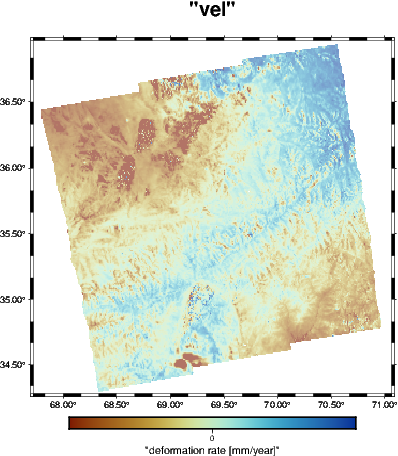

In [101]:
# test Milan nc reading code
import xarray as xr
xr.set_options(keep_attrs=True)

def pygmt_plot(grid, title, label='deformation rate [mm/year]', lims=[-25, 10],
               cmap="roma", photobg=False, plotvec=None):
    ''' Function to generate (nice) plot of given grid using pyGMT
    
    Args:
        grid (xr.DataArray): input grid to plot
        title (str):  title (note too long title will disbalance the figure)
        label (str):  label below the colour scale
        lims (list):  colour scale limits
        cmap (str):   colour scale map (try 'vik' for E-W)
        photobg (bool): will plot orthophotomap as the background (if False, DEM relief is used)
        plotvec (geopandas etc): will plot vector data to the map, using pyGMT defaults
    
    Returns:
        pygmt.figure.Figure
    '''
    try:
        grid = grid.load()
    except:
        print('error loading the input dataarray to memory')
        return False
    # try cmap 'vik' for E-W
    #
    # grid = a['U'].where(a.mask < 5) - 10
    # topo_data = '@earth_relief_03s' #3 arc second global relief (SRTM3S)
    topo_data = '@earth_relief_01s'  # 3 arc second global relief (SRTM3S)

    minlon, maxlon = float(np.min(grid.lon)), float(np.max(grid.lon))
    minlat, maxlat = float(np.min(grid.lat)), float(np.max(grid.lat))

    fig = pygmt.Figure()
    pygmt.config(FORMAT_GEO_MAP="ddd.xx") #, MAP_FRAME_TYPE="plain")
    projection = "M13c" # 'R13c' for Robinson etc.
    region = [minlon, maxlon, minlat, maxlat]
    fig.basemap(region=region, projection=projection, frame=["af", '+t"{0}"'.format(title)])

    if photobg:
        import contextily as ctx
        sourcetiles = ctx.providers.Esri.WorldImagery
        fig.tilemap(
            region=region, projection=projection,
            # region=[-157.84, -157.8, 21.255, 21.285],
            # projection="M12c",
            # Set level of details (0-22)
            # Higher levels mean a zoom level closer to the Earth's
            # surface with more tiles covering a smaller
            # geographic area and thus more details and vice versa
            # Please note, not all zoom levels are always available
            zoom=14,
            # Use tiles from OpenStreetMap tile server
            source=sourcetiles
        )
        pygmt.makecpt(cmap=cmap, series=lims, background=True)
        fig.grdview(grid=grid, cmap=True, projection=projection, surftype='c', transparency=40)
    else:
        pygmt.makecpt(cmap="gray", series=[-8000, 8000, 1000], continuous=True)
        fig.grdimage(
            grid=topo_data,
            cmap=True,
            region=[minlon, maxlon, minlat, maxlat],
            projection=projection,
            shading=True,
            frame=True
        )
        pygmt.makecpt(cmap=cmap, series=lims, background=True)
        fig.grdimage(grid=grid, cmap=True, projection=projection, frame=True, transparency=40)
    #
    fig.coast(shorelines=True, projection=projection)
    if type(plotvec) != type(None):
        fig.plot(plotvec, projection=projection, region=region)
    fig.colorbar(frame='a10+l"{}"'.format(label))
    # fig.show()
    return fig

a=xr.open_dataset("bin/"+InSAR_NetCDF); vel=a["vel"]; pygmt_plot(vel, title="vel", lims=[-4,4])